In [5]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib widget 
import sys

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
#from tinygp.helpers import JAXArray

if sys.version_info[1] < 10:
    raise Warning("You should be using Python 3.10 - tinygp may not work")

class LatentKernel(kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    try:
        kernel : kernels.Kernel
        coeff_prim: jax.Array | float
        coeff_deriv: jax.Array | float
    except:
        pass

    def __init__(self, kernel, coeff_prim, coeff_deriv):
        self.kernel = kernel
        self.coeff_prim, self.coeff_deriv = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]

        # Construct the matrix element
        return (
            a1 * a2 * K
            + a1 * b2 * dK_dx2
            + b1 * a2 * dK_dx1
            + b1 * b2 * d2K_dx1dx2
        )

def _build_tinygp_multidimensional(params):

    base_kernel = kernels.ExpSquared(scale=jnp.abs(params["Pdec"])) \
            * kernels.ExpSineSquared(
            scale=jnp.abs(params["Prot"]),
            gamma=jnp.abs(params["gamma"]))

    kernel = LatentKernel(base_kernel, params['coeff_prime'], params['coeff_deriv'])
    return GaussianProcess(
        kernel, X_obs, diag=jnp.abs(params['diag']), mean=0.0
    )

@jax.jit
def _loss_tinygp(params):
    gp = _build_tinygp_multidimensional(params)
    return -gp.log_probability(y_obs)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


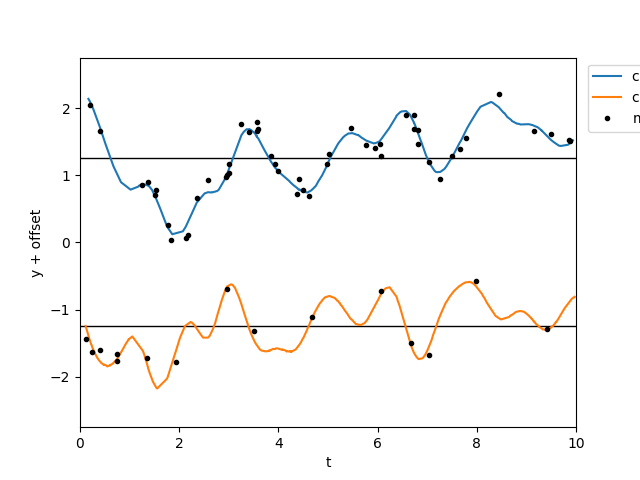

In [3]:
import tinygp 

base_kernel = tinygp.kernels.ExpSquared(scale=1.5) * tinygp.kernels.ExpSineSquared(
    scale=2.5, gamma=0.5
)

#    base_kernel = kernels.ExpSquared(scale=jnp.abs(params["Pdec"])) \
#            * kernels.ExpSineSquared(
#            scale=jnp.abs(params["Prot"]),
#            gamma=jnp.abs(params["gamma"]))


kernel = LatentKernel(base_kernel, [1.0, 0.5], [-0.1, 0.3])

random = np.random.default_rng(5678)
t1 = np.sort(random.uniform(0, 10, 200))
label1 = np.zeros_like(t1, dtype=int)
t2 = np.sort(random.uniform(0, 10, 300))
label2 = np.ones_like(t2, dtype=int)
X = (np.append(t1, t2), np.append(label1, label2))

gp = tinygp.GaussianProcess(kernel, X, diag=1e-5)
y = gp.sample(jax.random.PRNGKey(1234))

subset = np.append(
    random.integers(len(t1), size=50),
    len(t1) + random.integers(len(t2), size=15),
)
X_obs = (X[0][subset], X[1][subset])
y_obs = y[subset] + 0.1 * random.normal(size=len(subset))

offset = 2.5

plt.figure()
plt.axhline(0.5 * offset, color="k", lw=1)
plt.axhline(-0.5 * offset, color="k", lw=1)

plt.plot(t1, y[: len(t1)] + 0.5 * offset, label="class 0")
plt.plot(t2, y[len(t1) :] - 0.5 * offset, label="class 1")

plt.plot(X_obs[0], y_obs + offset * (0.5 - X_obs[1]), ".k", label="measured")

plt.xlim(0, 10)
plt.ylim(-1.1 * offset, 1.1 * offset)
plt.xlabel("t")
plt.ylabel("y + offset")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.show()

In [4]:
import jaxopt

init = {
    "Pdec": np.float64(1.5),
    "Prot": np.float64(2.5),
    "gamma": np.float64(0.5),
    "coeff_prime": np.array([1.0, 0.5]),
    "coeff_deriv": np.array([-0.1, 0.3]),
        "diag": np.float64(0.1),

}
print(f"Initial negative log likelihood: {_loss_tinygp(init)}")
solver = jaxopt.ScipyMinimize(fun=_loss_tinygp)
soln = solver.run(init)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Initial negative log likelihood: 18.547339999949955
Final negative log likelihood: -20.01400374854432


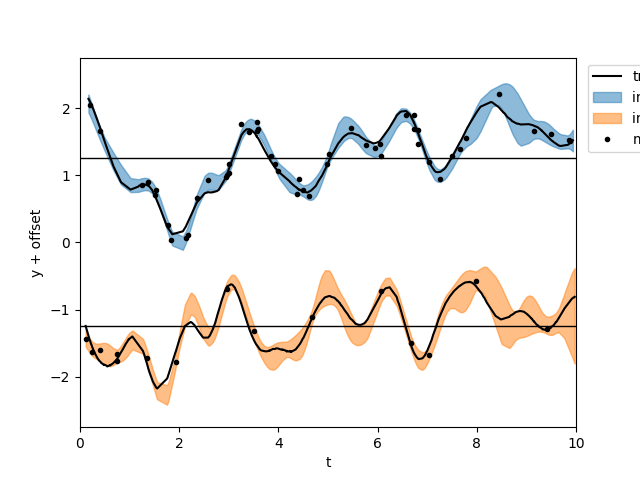

In [36]:
gp = _build_tinygp_multidimensional(soln.params)
gp_cond = gp.condition(y_obs, X).gp
mu, var = gp_cond.loc, gp_cond.variance

plt.figure()

plt.axhline(0.5 * offset, color="k", lw=1)
plt.axhline(-0.5 * offset, color="k", lw=1)

plt.plot(t1, y[: len(t1)] + 0.5 * offset, "k", label="truth")
plt.plot(t2, y[len(t1) :] - 0.5 * offset, "k")

for c in [0, 1]:
    delta = offset * (0.5 - c)
    m = X[1] == c
    plt.fill_between(
        X[0][m],
        delta + mu[m] + 2 * np.sqrt(var[m]),
        delta + mu[m] - 2 * np.sqrt(var[m]),
        color=f"C{c}",
        alpha=0.5,
        label=f"inferred class {c}",
    )

plt.plot(X_obs[0], y_obs + offset * (0.5 - X_obs[1]), ".k", label="measured")

plt.xlim(0, 10)
plt.ylim(-1.1 * offset, 1.1 * offset)
plt.xlabel("t")
plt.ylabel("y + offset")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.show()

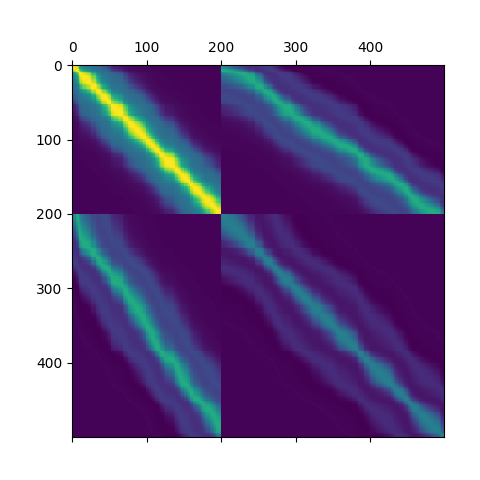

In [21]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
#from tinygp.helpers import JAXArray

if sys.version_info[1] < 10:
    raise Warning("You should be using Python 3.10 - tinygp may not work")

class LatentKernel_TEST(kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    try:
        kernel : kernels.Kernel
        coeff_prim: jax.Array | float
        coeff_deriv: jax.Array | float
    except:
        pass

    def __init__(self, kernel, coeff_prim, coeff_deriv):
        self.kernel = kernel
        self.coeff_prim, self.coeff_deriv = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]
        #print('A1', a1)
        #print('A2', a2)
        #print('B1', b1)
        #print('B2', b2)

        # Construct the matrix element
        return (
            a1 * a2 * K
            + a1 * b2 * dK_dx2
            + b1 * a2 * dK_dx1
            + b1 * b2 * d2K_dx1dx2
        )

params = {
    "Pdec": np.float64(1.5),
    "Prot": np.float64(2.5),
    "gamma": np.float64(0.5),
    "coeff_prime": np.array([1.0, 0.5]),
    "coeff_deriv": np.array([-0.1, 0.3]),
        "diag": np.float64(0.1),

}


base_kernel = kernels.ExpSquared(scale=jnp.abs(params["Pdec"])) \
        * kernels.ExpSineSquared(
        scale=jnp.abs(params["Prot"]),
        gamma=jnp.abs(params["gamma"]))

kernel = LatentKernel_TEST(base_kernel, [1.0, 0.5], [-0.1, 0.3])

K = LatentKernel_TEST(base_kernel, [1.0, 0.5], [-0.1, 0.3])(X, X)
plt.matshow(K)




ValueError: not enough values to unpack (expected 2, got 1)

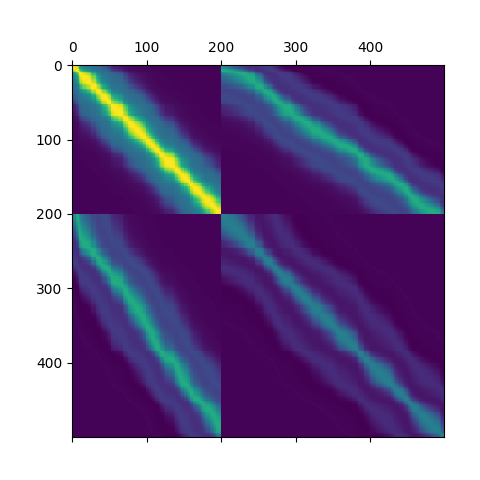

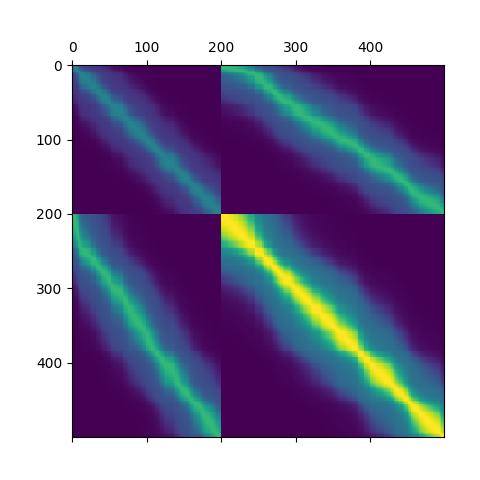

In [117]:

class LatentKernel_MODIF(kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    try:
        kernel : kernels.Kernel
        coeff_prim: jax.Array | float
        coeff_deriv: jax.Array | float
    except:
        pass

    def __init__(self, kernel, coeff_prim, coeff_deriv):
        self.kernel = kernel
        self.coeff_prim, self.coeff_deriv = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]

        # Construct the matrix element
        return (
            a1 * a2 * K
        )


class LatentKernel_MODIF2(kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    try:
        kernel : kernels.Kernel
        coeff_prim: jax.Array | float
        coeff_deriv: jax.Array | float
    except:
        pass

    def __init__(self, kernel, coeff_prim, coeff_deriv):
        self.kernel = kernel
        self.coeff_prim, self.coeff_deriv = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]

        
        #x1, x2 = jax.numpy.meshgrid(label1.val, label2.val)
        x_mesh, y_mesh = jnp.meshgrid(label1.val, label2.val)

        aa, bb = np.where(x_mesh != y_mesh)
        plt.matshow(aa)
        print(len(aa))
        print(len(bb))
        matrix_mult = a1 * a2 * K
        print(K)
        matrix_mult.val.val.at[aa,bb].set(0.0)
        print(matrix_mult.val.val)
        # Construct the matrix element
        return (
            matrix_mult
        )


base_kernel = kernels.ExpSquared(scale=jnp.abs(params["Pdec"])) \
        * kernels.ExpSineSquared(
        scale=jnp.abs(params["Prot"]),
        gamma=jnp.abs(params["gamma"]))

K1 = LatentKernel_TEST(base_kernel, [1.0, 0.5], [-0.1, 0.3])(X, X)
plt.matshow(K1)

K2 = LatentKernel_MODIF(base_kernel, [1.0, 1.5], [-0.1, 0.3])(X, X)
plt.matshow(K2)


K3 = LatentKernel_MODIF2(base_kernel, [1.0, 1.5], [-0.1, 0.3])(X, X)
plt.matshow(K3)

In [94]:
x = jnp.linspace(-2, 2, 10)
y = x
x_mesh, y_mesh = jnp.meshgrid(x, y)
print(x_mesh)


[[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
   0.66666667  1.11111111  1.55555556  2.        ]
 [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
   0.66666667  1.11111111  1.55555556  2.        ]
 [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
   0.66666667  1.11111111  1.55555556  2.        ]
 [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
   0.66666667  1.11111111  1.55555556  2.        ]
 [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
   0.66666667  1.11111111  1.55555556  2.        ]
 [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
   0.66666667  1.11111111  1.55555556  2.        ]
 [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
   0.66666667  1.11111111  1.55555556  2.        ]
 [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
   0.66666667  1.11111111  1.55555556  2.        ]
